<a href="https://colab.research.google.com/github/akashdeepjassal/Pruning/blob/main/Prune_Fashion_MNist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

from torch import nn, optim
from numpy import linalg as LA
from scipy.stats import rankdata
from collections import OrderedDict
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

### Some Sources
* Major Pruning Papers https://github.com/chenbong/awesome-compression-papers
* https://www.tensorflow.org/model_optimization/api_docs/python/tfmot
* https://jacobgil.github.io/deeplearning/pruning-deep-learning
* https://heartbeat.fritz.ai/research-guide-pruning-techniques-for-neural-networks-d9b8440ab10d#:~:text=Pruning%20is%20a%20technique%20in,values%20in%20the%20weight%20tensor.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#This is similar to LeNet by LeCun et al., 1998.
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
model = MyNet().to(device=device)

## Inspect Modules

In [ ]:
module = model.conv1
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

## Let's Prune a module

In [ ]:
prune.random_unstructured(module, name="weight", amount=0.3)

In [ ]:
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
print(module.weight)

In [ ]:
print(module._forward_pre_hooks)

In [ ]:
prune.l1_unstructured(module, name="bias", amount=3)

In [ ]:
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
print(module.bias)

In [ ]:
print(module._forward_pre_hooks)

## Iterative Pruning



In [ ]:
prune.ln_structured(module, name="weight", amount=0.5, n=2, dim=0)

# As we can verify, this will zero out all the connections corresponding to
# 50% (3 out of 6) of the channels, while preserving the action of the
# previous mask.
print(module.weight)

In [ ]:
for hook in module._forward_pre_hooks.values():
    if hook._tensor_name == "weight":  # select out the correct hook
        break

print(list(hook))  # pruning history in the container

## Serialization of a pruned model

In [ ]:
print(model.state_dict().keys())

## Remove pruning re-parametrization

In [ ]:
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

In [ ]:
print(module.weight)

In [ ]:
prune.remove(module, 'weight')
print(list(module.named_parameters()))

In [ ]:
print(list(module.named_buffers()))

## Pruning multiple parameters in a model

In [ ]:
new_model = MyNet()
for name, module in new_model.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)

print(dict(new_model.named_buffers()).keys())  # to verify that all masks exist

## Global pruning

In [ ]:
model = MyNet()

parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    # (model.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

In [ ]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv1.weight == 0))
        / float(model.conv1.weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.conv2.weight == 0))
        / float(model.conv2.weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc1.weight == 0))
        / float(model.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc2.weight == 0))
        / float(model.fc2.weight.nelement())
    )
)
# print(
#     "Sparsity in fc3.weight: {:.2f}%".format(
#         100. * float(torch.sum(model.fc3.weight == 0))
#         / float(model.fc3.weight.nelement())
#     )
# )
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model.conv1.weight == 0)
            + torch.sum(model.conv2.weight == 0)
            + torch.sum(model.fc1.weight == 0)
            + torch.sum(model.fc2.weight == 0)
            # + torch.sum(model.fc3.weight == 0)
        )
        / float(
            model.conv1.weight.nelement()
            + model.conv2.weight.nelement()
            + model.fc1.weight.nelement()
            + model.fc2.weight.nelement()
            # + model.fc3.weight.nelement()
        )
    )
)

##  Now Let's train a model and see prunnning in action

In [ ]:
!nvidia-smi

##Let's try prunning with a Dense model

In [ ]:

class MyNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 1000, bias=False)
        self.fc2 = nn.Linear(1000, 1000, bias=False)
        self.fc3 = nn.Linear(1000, 500, bias=False)
        self.fc4 = nn.Linear(500, 200, bias=False)
        self.fc5 = nn.Linear(200, 10, bias=False)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x), dim=1)
        return x

In [ ]:
model = MyNet1()

In [ ]:

# required variables 
import numpy as np
batch_size = 128  # batch size
valid_size = 0.2  # validation set size: 20%
epochs = 20  # number of epochs
min_valid_loss = np.Inf  # min value for validation loss
transform = transforms.ToTensor()  # necessary image transform i.e. conver tot Tensor

In [ ]:
# Download the Train and Test set

trainset = datasets.FashionMNIST('.', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST('.', train=False, download=True, transform=transform)

In [ ]:

# Split the training set indices into training and validation set indices using 80:20 ratio

len_trainset = len(trainset)
index_list = list(range(len_trainset))
np.random.shuffle(index_list)
split_index = int(len_trainset * valid_size)
train_indices, valid_indices = index_list[split_index:], index_list[:split_index]

In [ ]:

# Create Samplers for training and validation set using the indices

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [ ]:
# Create loaders for train, validation and testing set using samplers

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [ ]:
model=MyNet1()

In [ ]:

# Using CrossEntropy as my Loss function and Adam Optimizer with a learning rate of 0.01 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:

for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    model.train()
    # Training
    for image, label in trainloader:
        # Set Gradients to zero
        optimizer.zero_grad()
        # forward pass the image through the network
        output = model(image)
        # Get the loss
        loss = criterion(output, label)
        # Backward propagation
        loss.backward()
        # Optimization step
        optimizer.step()
        # Train loss is the loss multiplied by the batch size
        train_loss += loss.item() * image.size(0)
    model.eval()
    # Validation
    for image, label in validloader:
        # forward pass the image through the network
        output = model(image)
        # Get the loss
        loss = criterion(output, label)
        # Validation loss is the loss multiplied by the batch size
        valid_loss += loss.item() * image.size(0)

    # Total train loss is the average of train loss, same for validation loss
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
  
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch+1, 
      train_loss,
      valid_loss
      ))
    
    # save model only if validation loss has decreased
    if valid_loss <= min_valid_loss:
        print('Validation loss decreased ({} --> {}).  Saving model ...'.format(
        min_valid_loss,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        min_valid_loss = valid_loss

In [ ]:
# Function to check test accuracy

def test_accuracy(model, testloader, criterion):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()

    for data, target in testloader:
        # forward pass
        # data,target=data.to(device),target.to(device)
        output = model(data)
        # Get the loss
        loss = criterion(output, target)
        # Test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class and get the max class
        _, pred = torch.max(output, 1)
        # compare prediction with true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    # Overall accuracy
    overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
    return overall_accuracy

In [ ]:
initial_accuracy = test_accuracy(model, testloader, criterion)
print(initial_accuracy)

In [ ]:
# Prune ranges provided in the PDF

prune_percentage = [.0, .10, .15, .20, .25, .30, .35, .40, .45, .50, .55, .60, .65, .70, .75, .80, .90, .95, .97, .99]
accuracies_wp = []
accuracies_np = []

# Get the accuracy without any pruning 
initial_accuracy = test_accuracy(model, testloader, criterion)
accuracies_wp.append(initial_accuracy)
accuracies_np.append(initial_accuracy)

## Weight Pruning

In [ ]:
 
# Loop through each prune percent
for k in prune_percentage[1:]:
    # Load the original unprunned model
    model = MyNet1()
    model.load_state_dict(torch.load('model.pt'))
    # Get all the weights
    weights = model.state_dict()
    # Get keys to access model weights
    layers = list(model.state_dict())
    ranks = {}
    pruned_weights = []
    # For each layer except the output one
    for l in layers[:-1]:
        # Get weights for each layer and conver to numpy 
        data = weights[l]
        w = np.array(data)
        # Rank the weights element wise and reshape rank elements as the model weights
        ranks[l]=(rankdata(np.abs(w), method='dense') - 1).astype(int).reshape(w.shape)
        # Get the threshold value based on the value of k(prune percentage) 
        lower_bound_rank = np.ceil(np.max(ranks[l]) * k).astype(int)
        # Assign rank elements to 0 that are less than or equal to the threshold and 1 to those that are above.
        ranks[l][ranks[l] <= lower_bound_rank] = 0
        ranks[l][ranks[l] > lower_bound_rank] = 1
        # Multiply weights array with ranks to zero out the lower ranked weights
        w = w * ranks[l]
        # Assign the updated weights as tensor to data and append to the pruned_weights list 
        data[...] = torch.from_numpy(w)
        pruned_weights.append(data)
    # Append the last layer weights as it is
    pruned_weights.append(weights[layers[-1]])
    # Update the model weights with all the updated weights 
    new_state_dict = OrderedDict()
    for l, pw in zip(layers, pruned_weights):
        new_state_dict[l] = pw
    model.state_dict = new_state_dict
    # append the test accuracy to accuracies_wp
    accuracies_wp.append(test_accuracy(model, testloader, criterion))

## Neuron Pruning

In [ ]:
model

In [ ]:

# Code is almost same as above so comments are provided for only different parts of code
dense=True
for k in prune_percentage[1:]:
    model = MyNet1()
    model.load_state_dict(torch.load('model.pt'))
    weights = model.state_dict()
    layers = list(model.state_dict())
    ranks = {}
    pruned_weights = []
    for l in layers[:-1]:
        data = weights[l]
        w = np.array(data)
        # taking norm for each neuron
        norm = LA.norm(w, axis=0)
        # repeat the norm values to get the shape similar to that of layer weights
        norm = np.tile(norm, (w.shape[0],1))
        ranks[l] = (rankdata(norm, method='dense') - 1).astype(int).reshape(norm.shape)
        lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
        ranks[l][ranks[l] <= lower_bound_rank] = 0
        ranks[l][ranks[l] > lower_bound_rank] = 1
        if dense:
          w = w * ranks[l]
        data[...] = torch.from_numpy(w)
        pruned_weights.append(data)
    pruned_weights.append(weights[layers[-1]])
    new_state_dict = OrderedDict()
    for l, pw in zip(layers, pruned_weights):
        new_state_dict[l] = pw
    model.state_dict = new_state_dict
    accuracies_np.append(test_accuracy(model, testloader, criterion))

In [ ]:
# Plot the sparsity vs accuracy graph

import matplotlib.pyplot as plt
plt.plot(prune_percentage, accuracies_np, label='Neuron Pruning')
plt.plot(prune_percentage, accuracies_wp, label='Weight Pruning')
plt.legend(loc='best')
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')
plt.show()

# Prune Conv2D model


In [ ]:
# Function to check test accuracy

def test_accuracy(model, testloader, criterion):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()

    for data, target in testloader:
        # forward pass
        data,target=data.to(device),target.to(device)
        output = model(data)
        # Get the loss
        loss = criterion(output, target)
        # Test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class and get the max class
        _, pred = torch.max(output, 1)
        # compare prediction with true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    # Overall accuracy
    overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
    return overall_accuracy

In [ ]:
# new_model
new_model = MyNet().to(device=device)


# Using CrossEntropy as my Loss function and Adam Optimizer with a learning rate of 0.01 
batch_size = 128  # batch size
valid_size = 0.2  # validation set size: 20%
epochs = 50  # number of epochs
min_valid_loss = np.Inf  # min value for validation loss
transform = transforms.ToTensor()  # necessary image transform i.e. conver tot Tensor
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(new_model.parameters(), lr=0.001,
                      momentum=momentum)

for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    new_model.train()
    # Training
    for image, label in trainloader:
        # Set Gradients to zero
        optimizer.zero_grad()
        image, label=image.to(device),label.to(device)
        # forward pass the image through the network
        output = new_model(image)
        # Get the loss
        loss = criterion(output, label)
        # Backward propagation
        loss.backward()
        # Optimization step
        optimizer.step()
        # Train loss is the loss multiplied by the batch size
        train_loss += loss.item() * image.size(0)
    new_model.eval()
    # Validation
    for image, label in validloader:
        # forward pass the image through the network
        image, label=image.to(device),label.to(device)
        output = new_model(image)
        # Get the loss
        loss = criterion(output, label)
        # Validation loss is the loss multiplied by the batch size
        valid_loss += loss.item() * image.size(0)

    # Total train loss is the average of train loss, same for validation loss
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
  
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch+1, 
      train_loss,
      valid_loss
      ))
    
    # save model only if validation loss has decreased
    if valid_loss <= min_valid_loss:
        print('Validation loss decreased ({} --> {}).  Saving model ...'.format(
        min_valid_loss,
        valid_loss))
        torch.save(new_model.state_dict(), 'model1.pt')
        min_valid_loss = valid_loss
    initial_accuracy = test_accuracy(new_model, testloader, criterion)
    print(initial_accuracy)


In [ ]:
initial_accuracy = test_accuracy(new_model, testloader, criterion)
print(initial_accuracy)

# Test Accuracy after Pruning multiple parameters in a model

In [ ]:
new_model1= MyNet().to(device=device)
# new_model1=new_model
new_model1.load_state_dict(torch.load('model1.pt'))
for name, module in new_model1.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.01)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.02)

print(dict(new_model1.named_buffers()).keys())  # to verify that all masks exist
initial_accuracy = test_accuracy(new_model1, testloader, criterion)
print(initial_accuracy)

In [ ]:
new_model1= MyNet().to(device=device)
# new_model1=new_model
new_model1.load_state_dict(torch.load('model1.pt'))
for name, module in new_model1.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.1)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.2)

print(dict(new_model1.named_buffers()).keys())  # to verify that all masks exist
initial_accuracy = test_accuracy(new_model1, testloader, criterion)
print(initial_accuracy)

In [ ]:
new_model1= MyNet().to(device=device)
# new_model1=new_model
new_model1.load_state_dict(torch.load('model1.pt'))
for name, module in new_model1.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)

print(dict(new_model1.named_buffers()).keys())  # to verify that all masks exist
initial_accuracy = test_accuracy(new_model1, testloader, criterion)
print(initial_accuracy)

# Test after global prunning

In [ ]:
!nvidia-smi

In [ ]:
torch.cuda.empty_cache() # PyTorch thing

In [ ]:
new_model2= MyNet().to(device=device)
new_model2.load_state_dict(torch.load('model1.pt'))
# new_model2=new_model
model = new_model2

parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    # (model.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.15,   
)
initial_accuracy = test_accuracy(new_model2, testloader, criterion)
print(initial_accuracy)

In [ ]:

new_model2= MyNet().to(device=device)
new_model2.load_state_dict(torch.load('model1.pt'))
# new_model2=new_model
model = new_model2

parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    # (model.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.25,   
)
initial_accuracy = test_accuracy(new_model2, testloader, criterion)
print(initial_accuracy)

In [68]:
prune_percentage = [0.01,0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.90, 0.95, 0.97, 0.99]
index=[x for x in range(len(prune_percentage))]
accuracies_wp = []
accuracies_np = []

for k in prune_percentage:
    # model = MyNet()
    # model.load_state_dict(torch.load('model1.pt'))
    new_model2= MyNet().to(device=device) 
    new_model2.load_state_dict(torch.load('model1.pt'))
    model=new_model2
    weights = model.state_dict()
    parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    # (model.fc3, 'weight'),
    )
    prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=k,   
    )
    initial_accuracy = test_accuracy(model, testloader, criterion)
    print(k,":",initial_accuracy)
    accuracies_np.append(test_accuracy(model, testloader, criterion))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.01 : 82.26
0.1 : 82.35
0.15 : 82.29
0.2 : 82.25
0.25 : 81.96
0.3 : 81.9
0.35 : 82.0
0.4 : 82.19
0.45 : 82.01
0.5 : 81.95
0.55 : 81.88
0.6 : 82.09
0.65 : 80.69
0.7 : 79.72
0.75 : 78.62
0.8 : 75.65
0.9 : 36.19
0.95 : 12.37
0.97 : 10.03
0.99 : 10.0


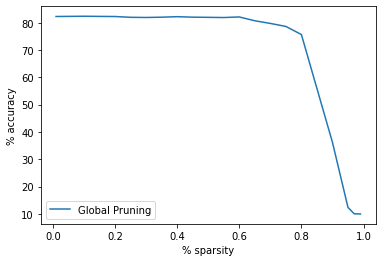

In [69]:
# Plot the sparsity vs accuracy graph

import matplotlib.pyplot as plt
plt.plot(prune_percentage, accuracies_np, label='Global Pruning')
# plt.plot(prune_percentage, accuracies_wp, label='Weight Pruning')
plt.legend(loc='best')
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')
plt.show()